In [106]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pyopencl as cl
from tqdm import tqdm
import os

def load_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return image

def compute_gradients(image):
    gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    return gradient_x, gradient_y

def compute_structure_tensor(gradient_x, gradient_y):
    Jxx = gradient_x ** 2
    Jyy = gradient_y ** 2
    Jxy = gradient_x * gradient_y
    return Jxx, Jyy, Jxy

def gaussian_blur(image, kernel_size, sigma):
    return cv2.GaussianBlur(image, kernel_size, sigma)

def compute_etf(Jxx, Jyy, Jxy):
    etf_map = np.zeros_like(Jxx)
    for i in tqdm(range(Jxx.shape[0])):
        for j in range(Jxx.shape[1]):
            J = np.array([[Jxx[i, j], Jxy[i, j]], [Jxy[i, j], Jyy[i, j]]])
            eigenvalues, eigenvectors = np.linalg.eig(J)
            idx_min_ev = np.argmin(eigenvalues)
            etf_map[i, j] = np.arctan2(eigenvectors[1, idx_min_ev], eigenvectors[0, idx_min_ev])
    return etf_map
# --------- Bluring accros Etf Map -----------
def anisotropic_gaussian_blur_opencl(image, etf_map, kernel_size, sigma):
    # Set up OpenCL context and queue
    os.environ['PYOPENCL_CTX'] = '0'
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)

    # Load OpenCL kernel source code
    kernel_source = open('anisotropic_gaussian_blur.cl').read()

    # Create OpenCL program and kernel
    program = cl.Program(ctx, kernel_source).build()
    kernel = program.anisotropic_gaussian_blur

    # Prepare input and output buffers
    mf = cl.mem_flags
    image_float32 = image.astype(np.float32)
    etf_map_float32 = etf_map.astype(np.float32)
    image_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=image_float32)
    etf_map_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=etf_map_float32)
    output_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=image_float32.nbytes)

    # Set kernel arguments
    kernel.set_args(image_buf, etf_map_buf, np.int32(image.shape[0]), np.int32(image.shape[1]),
                    np.int32(kernel_size), np.float32(sigma), output_buf)

    # Execute the kernel
    global_size = (image.shape[0], image.shape[1])  # Swap dimensions for OpenCL
    local_size = None
    event = cl.enqueue_nd_range_kernel(queue, kernel, global_size, local_size)
    event.wait()  # Wait for the kernel to finish execution

    # Debugging statements
    blurred_image = np.empty_like(image_float32)
    print("Data type of blurred_image:", blurred_image.dtype)
    print("Shape of blurred_image:", blurred_image.shape)
    print("Size of output_buf:", output_buf.size)
    print("Image size (bytes):", image_float32.nbytes)
    print("Output buffer size (bytes):", output_buf.size)

    # Read the output buffer and copy the result to a NumPy array
    cl.enqueue_copy(queue, blurred_image, output_buf).wait()

    return blurred_image
# ------ Line Integral Convolution Smoothing
def create_square_gaussian_kernel(size, sigma):
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    sigma2 = 2 * sigma * sigma

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            kernel[i, j] = np.exp(-(x*x + y*y) / sigma2)

    return kernel / np.sum(kernel)

def edge_aligned_smoothing_filter_opencl(image, etf_map, kernel_size, sigma):
     # Set up OpenCL context and queue
    os.environ['PYOPENCL_CTX'] = '0'
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)

    # Load OpenCL kernel source code
    kernel_source = open('edge_aligned_smoothing_filter.cl').read()

    # Create OpenCL program and kernel
    program = cl.Program(ctx, kernel_source).build()
    kernel = program.edge_aligned_smoothing_filter

    # Prepare input and output buffers
    mf = cl.mem_flags
    image_float32 = image.astype(np.float32) # NBNB MAKE SURE RIGHT SIZE
    etf_map_float32 = etf_map.astype(np.float32)
    image_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=image_float32)
    etf_map_buf = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=etf_map_float32)
    output_buf = cl.Buffer(ctx, mf.WRITE_ONLY, size=image_float32.nbytes)

    # Set kernel arguments
    kernel.set_args(image_buf, etf_map_buf, np.int32(image.shape[0]), np.int32(image.shape[1]),
                    np.int32(kernel_size), np.float32(sigma), output_buf)

    # Execute the kernel
    global_size = (image.shape[0], image.shape[1])
    local_size = None
    event = cl.enqueue_nd_range_kernel(queue, kernel, global_size, local_size)
    event.wait()

    # Read the output buffer and copy the result to a NumPy array
    smoothed_image = np.empty_like(image_float32)
    cl.enqueue_copy(queue, smoothed_image, output_buf).wait()

    return smoothed_image

100%|██████████| 960/960 [00:14<00:00, 68.31it/s]


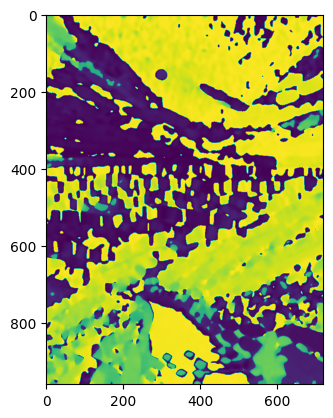

In [241]:
# Load the image
image_name = 'natuurrlik.jpg'
image = load_image(image_name)

# Compute gradients
gradient_x, gradient_y = compute_gradients(image)

# Compute structure tensor
Jxx, Jyy, Jxy = compute_structure_tensor(gradient_x, gradient_y)

# Apply Gaussian blur to structure tensor components
kernel_size = (0, 0)
sigma_c = 5
Jxx_blurred = gaussian_blur(Jxx, kernel_size, sigma_c)
Jyy_blurred = gaussian_blur(Jyy, kernel_size, sigma_c)
Jxy_blurred = gaussian_blur(Jxy, kernel_size, sigma_c)

# Compute ETF map
etf_map = compute_etf(Jxx_blurred, Jyy_blurred, Jxy_blurred)
plt.imshow(etf_map)
plt.show()


Data type of blurred_image: float32
Shape of blurred_image: (960, 720)
Size of output_buf: 2764800
Image size (bytes): 2764800
Output buffer size (bytes): 2764800
Data type of blurred_image: float32
Shape of blurred_image: (960, 720)
Size of output_buf: 2764800
Image size (bytes): 2764800
Output buffer size (bytes): 2764800


c:\Users\Tumi\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyopencl\cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(


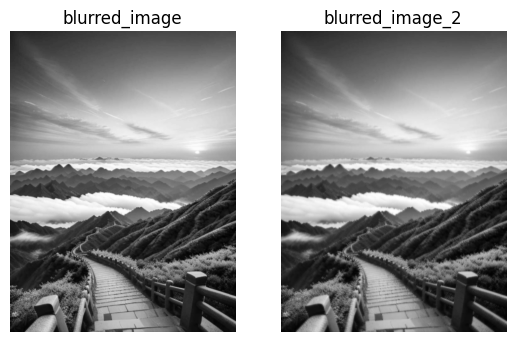

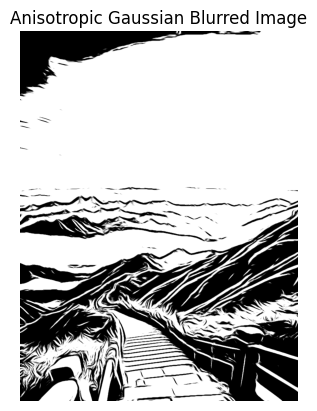

In [242]:
# ---------Tunables ----------
sigma_e = 1.4  # Adjust this value as needed
sigma_m = 13.2
p = 18.2
phi = 10.3 # Sensitivity parameter for the continuous ramp
epsilon = 73.1  # Threshold parameter
sigma_a = 1.95




# ---------- DoG accross Vector direction of ETF ------------
kernel_size = 31  # Adjust this value as needed

k = 1.6

blurred_image = anisotropic_gaussian_blur_opencl(image, etf_map, kernel_size, sigma_e)
plt.subplot(1, 2, 1)
plt.imshow(blurred_image, cmap='gray')
plt.title('blurred_image')
plt.axis('off')

blurred_image_2 = anisotropic_gaussian_blur_opencl(image, etf_map, kernel_size, sigma_e * k)
plt.subplot(1, 2, 2)
plt.imshow(blurred_image_2, cmap='gray')
plt.title('blurred_image_2')
plt.axis('off')
plt.show()

fdog = (1+p)*blurred_image - p*blurred_image_2

kernel_size = sigma_m * 6 +1
# ------- aligned blur Lic --------
aligned_blur = edge_aligned_smoothing_filter_opencl(fdog, etf_map, kernel_size, sigma_m)

# ------- Threshold -----------
def continuous_ramp(u, epsilon, phi):
        return np.where(u >= epsilon, 1, 1 + np.tanh(phi * (u - epsilon)))
    


xdog_result = continuous_ramp(aligned_blur, epsilon, phi)
# ------------ Anti-Ailiasing Lic ----------------

kernel_size = sigma_a * 6 +1
aligned_blur = edge_aligned_smoothing_filter_opencl(xdog_result, etf_map, kernel_size, sigma_a)
plt.imshow(aligned_blur, cmap='gray')
plt.title('Anisotropic Gaussian Blurred Image')
plt.axis('off')
plt.show()

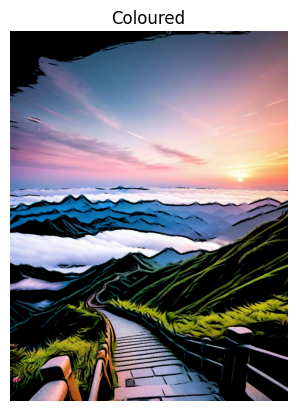

In [243]:


def blend_images(colored_image, edge_image):
    # Ensure both images are in the same range
    edge_image = cv2.normalize(edge_image, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    colored_image = colored_image.astype(np.float32) / 255.0
    # Initialize the blended image
    blended_image = np.zeros_like(colored_image)
    
    # Multiply each color channel by the edge-preserved grayscale image
    for c in range(3):
        blended_image[:, :, c] = colored_image[:, :, c] * edge_image
    
    # Scale back to 8-bit range if needed
    blended_image = (blended_image * 255).astype(np.uint8)
    
    return blended_image

image_col = cv2.imread(image_name)
image_col = cv2.cvtColor(image_col, cv2.COLOR_BGR2RGB)
image_col = cv2.GaussianBlur(image_col,(0,0),1)
blended_image = blend_images(image_col,aligned_blur)

plt.imshow(blended_image)
plt.title('Coloured')
plt.axis('off')
plt.show()

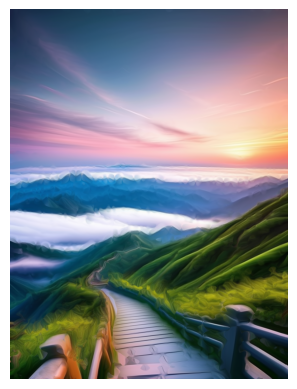

In [244]:
# ---- vincent van gogh ---- 
image_bgr = cv2.imread(image_name)
image_b, image_g, image_r = cv2.split(image_bgr)

image_r_float32 = image_r.astype(np.float32)
image_g_float32 = image_g.astype(np.float32)
image_b_float32 = image_b.astype(np.float32)


sigma_v = 20
kernel_size = int(sigma_v*6+1)
smoothed_r = edge_aligned_smoothing_filter_opencl(image_r_float32, etf_map, kernel_size, sigma_v)
smoothed_g = edge_aligned_smoothing_filter_opencl(image_g_float32, etf_map, kernel_size, sigma_v)
smoothed_b = edge_aligned_smoothing_filter_opencl(image_b_float32, etf_map, kernel_size, sigma_v)

smoothed_image = cv2.merge([smoothed_b.astype(np.uint8), smoothed_g.astype(np.uint8), smoothed_r.astype(np.uint8)])
blended_image = blend_images(smoothed_image,aligned_blur)
plt.imshow(cv2.cvtColor(smoothed_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

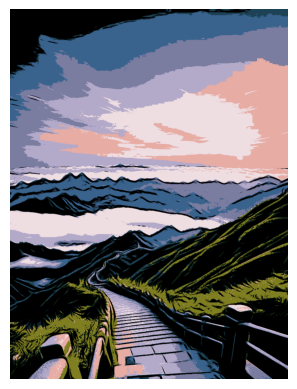

In [245]:
import cv2
import numpy as np

def cartoonize_image(image_path, k=8):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to float
    data = np.float32(image).reshape((-1, 3))
    
    # Define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, label, center = cv2.kmeans(data, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
    # Convert back to 8-bit values
    center = np.uint8(center)
    res = center[label.flatten()]
    quantized_image = res.reshape((image.shape))
    
    return quantized_image

# Path to your image

# Cartoonize the image
cartoon_image = cartoonize_image(image_name)

# Display the result
blended_image = blend_images(cartoon_image,aligned_blur)
plt.imshow(blended_image)
plt.axis('off')
plt.show

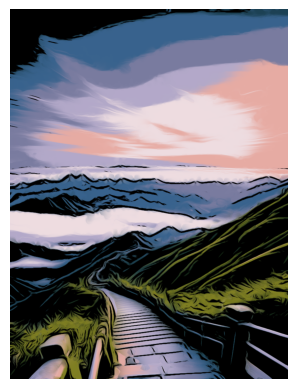

In [247]:
# --------- Kmeans smeared + edges ------------

image_bgr = cv2.cvtColor(cartoon_image, cv2.COLOR_BGR2RGB)
image_b, image_g, image_r = cv2.split(image_bgr)

image_r_float32 = image_r.astype(np.float32)
image_g_float32 = image_g.astype(np.float32)
image_b_float32 = image_b.astype(np.float32)


sigma_v = 20
kernel_size = int(sigma_v*6+1)
smoothed_r = edge_aligned_smoothing_filter_opencl(image_r_float32, etf_map, kernel_size, sigma_v)
smoothed_g = edge_aligned_smoothing_filter_opencl(image_g_float32, etf_map, kernel_size, sigma_v)
smoothed_b = edge_aligned_smoothing_filter_opencl(image_b_float32, etf_map, kernel_size, sigma_v)

smoothed_image = cv2.merge([smoothed_b.astype(np.uint8), smoothed_g.astype(np.uint8), smoothed_r.astype(np.uint8)])
blended_image = blend_images(smoothed_image,aligned_blur)
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()